<a href="https://colab.research.google.com/github/KelvinLam05/SMS-Spam-Detection/blob/main/Spam_Detection_in_SMS_(text)_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal of the project**

In this notebook, we will build a simple, fast, and accurate English-language text classification model with minimal effort. More specifically, we will build a model that classifies text messages as either spam or not.

**Data set information**

The dataset contains one set of text messages in English of 1082 messages, tagged acording being non-spam or spam.


**Attribute information**

* Message body : Contains the raw text

* Label : Contains the label (non-spam or spam) 


In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import ktrain
import tensorflow as tf
from ktrain import text
from sklearn.model_selection import train_test_split

In [ ]:
# Load dataset
df = pd.read_csv('/content/SMS_text_messages.csv')

In [ ]:
# Examine the data
df.head()

,Message_body,Label
0,Rofl. Its true to its name,Non-Spam
1,The guy did some bitching but I acted like i'd...,Non-Spam
2,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,Will ü b going to esplanade fr home?,Non-Spam
4,This is the 2nd time we have tried 2 contact u...,Spam


In [ ]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Message_body  1082 non-null   object
 1   Label         1082 non-null   object
dtypes: object(2)
memory usage: 17.0+ KB


**Preprocessing**

In [ ]:
# Rename Pandas columns to lower case
df.columns= df.columns.str.lower()

In [ ]:
# Checking for missing values
df.isnull().sum().sort_values(ascending = False)

label           0
message_body    0
dtype: int64

In [ ]:
# Checking the distribution of classes
df['label'].value_counts() 

Non-Spam    884
Spam        198
Name: label, dtype: int64

It is evident, that the dataset is imbalanced.

Let's make a new column to detect how long the text messages are:

In [ ]:
df['message_length'] = df['message_body'].apply(lambda x: len(x))

In [ ]:
df['message_length'].describe()

count    1082.000000
mean       82.894640
std        56.432321
min         2.000000
25%        37.000000
50%        66.500000
75%       132.000000
max       446.000000
Name: message_length, dtype: float64

The maximum length of a text message is 446 characters. 

**SMS message length**

The character limit for a single SMS message is technically 160 characters. However, most modern phones and networks support message concatenation: they split large messages into individual SMS messages (called "segments") and then re-create the large message at the receiving end. 

**Split the train and test data**

In [ ]:
X = df.drop(['label'], axis = 1)

In [ ]:
y = df['label']

In [ ]:
# Isolate X and y variables, and perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True, stratify = y)

**Encode target labels**

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()

In [ ]:
y_train_enc = y_train.copy()

In [ ]:
y_train_enc = pd.DataFrame(data = y_train_enc, columns = ['label'])

In [ ]:
y_train_enc['label_encoded'] = le.fit_transform(y_train_enc['label'].values)

In [ ]:
y_train_enc

,label,label_encoded
95,Non-Spam,0
1052,Non-Spam,0
542,Non-Spam,0
550,Non-Spam,0
808,Spam,1
...,...,...
358,Non-Spam,0
456,Spam,1
630,Non-Spam,0
293,Non-Spam,0


In [ ]:
y_train_enc['label_encoded'].unique()

array([0, 1])

In [ ]:
# Label encode the target variable 
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

**Preprocess data and build a transformer model**

With the Transformer API in ktrain, we can select any Hugging Face transformers model appropriate for our data. Since we are dealing with SMS spam, we will use smaller BERT by the author mrm8488.


In [ ]:
# Transformer model
MODEL_NAME = 'mrm8488/bert-tiny-finetuned-sms-spam-detection' 

We must supply a class_names argument to the Transformer constructor, which tells ktrain how indices map to class names. In this case, class_names = ['Non-Spam', 'Spam'] because 0 = Non-Spam, 1 = Spam.

In [ ]:
t = text.Transformer(MODEL_NAME, maxlen = 500, class_names = ['Non-Spam', 'Spam'])

In [ ]:
# Convert training set into a list
X_tr = pd.DataFrame(data = X_train, columns = ['message_body'])
X_tr = X_tr['message_body'].tolist()

In [ ]:
y_tr = pd.DataFrame(data = y_train, columns = ['label'])
y_tr = y_tr['label'].tolist()

In [ ]:
# Convert testing set into a list
X_te = pd.DataFrame(data = X_test, columns = ['message_body'])
X_te = X_te['message_body'].tolist()

In [ ]:
y_te = pd.DataFrame(data = y_test, columns = ['label'])
y_te = y_te['label'].tolist()

In [ ]:
# Preprocessing training and testing set 
trn = t.preprocess_train(X_tr, y_tr)
val = t.preprocess_test(X_te, y_te)

preprocessing train...
language: en
train sequence lengths:
	mean : 16
	95percentile : 32
	99percentile : 50


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 16
	95percentile : 33
	99percentile : 47


In [ ]:
# Model classifier
model = t.get_classifier()

404 Client Error: Not Found for url: https://huggingface.co/mrm8488/bert-tiny-finetuned-sms-spam-detection/resolve/main/tf_model.h5
/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:1067: UserWarning: Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn('Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. ' +\


In [ ]:
# Wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 6)

**Estimate a good learning rate**

To train the model, we will first find the optimal learning rate that suits well to our problem. ktrain provides a very good method named lr_find which trains the model at different learning rates and plots loss of the model as the learning rate is increased.

In [ ]:
# Briefly simulate training to find good learning rate
learner.lr_find(max_epochs = 1) 

simulating training for different learning rates... this may take a few moments...
144/144 [==============================] - 10s 41ms/step - loss: 1.1120 - accuracy: 0.8919


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


The learning rate plot can be observed by calling the following method:

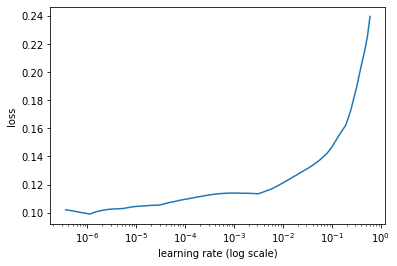

In [ ]:
# Visually identify best learning rate
learner.lr_plot()

We can observe that the classifier provides minimal loss when the learning rate is 1e-6.

We will now train the model using the autofit method. The method trains the classifier and automatically selects the best performing one preventing underfitting and overfitting of the model.

In [ ]:
# Training using the 1cycle policy
learner.autofit(1e-6, early_stopping = 5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 1e-06...
Epoch 1/1024
145/145 [==============================] - 12s 54ms/step - loss: 0.1263 - accuracy: 0.9780 - val_loss: 0.0792 - val_accuracy: 0.9954
Epoch 2/1024
145/145 [==============================] - 7s 48ms/step - loss: 0.1275 - accuracy: 0.9803 - val_loss: 0.0779 - val_accuracy: 0.9954
Epoch 3/1024
145/145 [==============================] - 7s 48ms/step - loss: 0.1208 - accuracy: 0.9780 - val_loss: 0.0767 - val_accuracy: 0.9954
Epoch 4/1024
145/145 [==============================] - 7s 48ms/step - loss: 0.1242 - accuracy: 0.9746 - val_loss: 0.0755 - val_accuracy: 0.9954
Epoch 5/1024
145/145 [==============================] - 7s 48ms/step - loss: 0.1183 - accuracy: 0.9792 - val_loss: 0.0744 - val_accuracy: 0.9954
Epoch 6/1024
145/145 [==============================] - 7s 47ms/step - loss: 0.1157 - accuracy: 0.9815 - val_loss: 0.0732 - val_accuracy: 0.9

**Evaluate/Inspect model**

Macro-average is preferable if there is a class imbalance problem.

With macro-average, a classifier is encouraged to try to recognize every class correctly. Since it is usually harder for the classifier to identify the small classes, this often makes it sacrifice some performance on the large classes.

Whereas with micro-average, a classifier is encouraged to focus on the largest classes, possibly at the expense of the smallest ones.

In [ ]:
# Evaluate model
learner.validate(class_names = t.get_classes())

              precision    recall  f1-score   support

    Non-Spam       1.00      1.00      1.00       177
        Spam       1.00      1.00      1.00        40

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217



array([[177,   0],
       [  0,  40]])

We are able to achieve a macro-averaged accuracy of 100%.

**Preprocess data and build a transformer model**

In [ ]:
# Transformer model
MODEL_NAME = 'sureshs/distilbert-large-sms-spam'  

In [ ]:
t = text.Transformer(MODEL_NAME, maxlen = 500, class_names = ['Non-Spam', 'Spam'])

In [ ]:
# Convert training set into a list
X_tr = pd.DataFrame(data = X_train, columns = ['message_body'])
X_tr = X_tr['message_body'].tolist()

In [ ]:
y_tr = pd.DataFrame(data = y_train, columns = ['label'])
y_tr = y_tr['label'].tolist()

In [ ]:
# Convert testing set into a list
X_te = pd.DataFrame(data = X_test, columns = ['message_body'])
X_te = X_te['message_body'].tolist()

In [ ]:
y_te = pd.DataFrame(data = y_test, columns = ['label'])
y_te = y_te['label'].tolist()

In [ ]:
# Preprocessing training and testing set 
trn = t.preprocess_train(X_tr, y_tr)
val = t.preprocess_test(X_te, y_te)

preprocessing train...
language: en
train sequence lengths:
	mean : 16
	95percentile : 32
	99percentile : 50


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 16
	95percentile : 33
	99percentile : 47


In [ ]:
# Model classifier
model = t.get_classifier()

404 Client Error: Not Found for url: https://huggingface.co/sureshs/distilbert-large-sms-spam/resolve/main/tf_model.h5
/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:1067: UserWarning: Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn('Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. ' +\


In [ ]:
# Wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 6)

**Estimate a good learning rate**

In [ ]:
# Briefly simulate training to find good learning rate
learner.lr_find(max_epochs = 1) 

simulating training for different learning rates... this may take a few moments...
144/144 [==============================] - 63s 364ms/step - loss: 0.1241 - accuracy: 0.9912


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


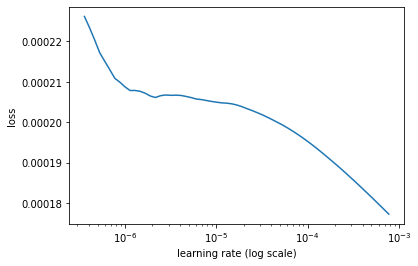

In [ ]:
# Visually identify best learning rate
learner.lr_plot()

In [ ]:
# Training using the 1cycle policy
learner.autofit(1e-3, early_stopping = 5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/1024
145/145 [==============================] - 115s 724ms/step - loss: 0.1590 - accuracy: 0.9607 - val_loss: 0.1133 - val_accuracy: 0.9677
Epoch 2/1024
145/145 [==============================] - 102s 703ms/step - loss: 0.2458 - accuracy: 0.8994 - val_loss: 0.2194 - val_accuracy: 0.8157
Epoch 3/1024
145/145 [==============================] - ETA: 0s - loss: 0.3044 - accuracy: 0.8058
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.0005 (if not early_stopping).
145/145 [==============================] - 102s 703ms/step - loss: 0.3044 - accuracy: 0.8058 - val_loss: 0.3037 - val_accuracy: 0.8157
Epoch 4/1024
145/145 [==============================] - 102s 703ms/step - loss: 0.3927 - accuracy: 0.8012 - val_loss: 0.4781 - val_accuracy: 0.8157
Epoch 5/1024
145/145 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.8173


**Evaluate/Inspect model**

In [ ]:
# Evaluate model
learner.validate(class_names = t.get_classes())

              precision    recall  f1-score   support

    Non-Spam       1.00      0.96      0.98       177
        Spam       0.85      1.00      0.92        40

    accuracy                           0.97       217
   macro avg       0.93      0.98      0.95       217
weighted avg       0.97      0.97      0.97       217



array([[170,   7],
       [  0,  40]])

We are able to achieve a macro-averaged accuracy of 95%.

**Conclusion**

The best result among all the two models we trained belongs to smaller BERT. We were able to achieve a macro-averaged accuracy of 100% with a good f1-score for each of the predicted classes.